In [18]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def load_data(filepath):
    df = pd.read_csv(filepath)
    print("Data Loaded Successfully!")
    print(df.describe())
    return df

In [3]:
def preprocess_data(df):
    X = df.iloc[:, 1:-1].values
    y = df.iloc[:, -1].values
    
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"Original Features: {X.shape[1]}, Reduced Features: {X_pca.shape[1]}")
    return X_pca, y

In [4]:
def train_models(X_train, y_train):
    models = {}
    
    rf = RandomForestRegressor(n_estimators=500, max_depth=20, max_features=0.7, bootstrap=False, min_samples_split=5, random_state=42)
    rf.fit(X_train, y_train)
    models['RandomForest'] = rf
    
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=9, colsample_bytree=0.8, subsample=0.8, gamma=0.25, min_child_weight=1, random_state=42)
    xgb.fit(X_train, y_train)
    models['XGBoost'] = xgb
    
    return models

In [21]:
def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

In [6]:
def build_cnn(input_shape):
    model = Sequential([
        Conv1D(256, kernel_size=1, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(128, kernel_size=1, activation='relu'),
        BatchNormalization(),
        Conv1D(64, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation=LeakyReLU(alpha=0.01)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [7]:
def train_cnn(model, X_train, y_train, X_test, y_test):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    
    history = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler], verbose=1)
    return model, history


In [15]:
def evaluate_cnn_model(model, X_test, y_test):
    y_pred = model.predict(X_test).squeeze()  # Using .squeeze() to remove single-dimensional entries
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"CNN Model Evaluation:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    return y_pred

In [8]:
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
def check_residual_normality(y_true, y_preds):
    residuals = y_true - y_preds
    plt.figure(figsize=(10, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Residuals Histogram")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot for Residuals")
    plt.show()

In [16]:
def main():
    df = load_data('TASK-ML-INTERN.csv')
    X_pca, y = preprocess_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    models = train_models(X_train, y_train)
    evaluate_models(models, X_test, y_test)
    
    X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)
    cnn_model = build_cnn((X_train_cnn.shape[1], 1))
    cnn_model, history = train_cnn(cnn_model, X_train_cnn, y_train, X_test_cnn, y_test)
    
    plot_loss(history)
    
    y_pred_cnn = evaluate_cnn_model(cnn_model, X_test_cnn, y_test)
    check_residual_normality(y_test, y_pred_cnn)


Data Loaded Successfully!
                0           1           2           3           4           5  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.443118    0.440761    0.433814    0.426122    0.418990    0.412432   
std      0.044719    0.045520    0.045764    0.046070    0.045405    0.044727   
min      0.311182    0.295321    0.284064    0.282054    0.296702    0.286860   
25%      0.410456    0.404310    0.397038    0.389029    0.382102    0.377157   
50%      0.449105    0.442651    0.434215    0.425074    0.417075    0.411872   
75%      0.480245    0.478822    0.473158    0.464947    0.459232    0.452198   
max      0.556287    0.530168    0.528774    0.533202    0.511909    0.501786   

                6           7           8           9  ...         439  \
count  500.000000  500.000000  500.000000  500.000000  ...  500.000000   
mean     0.405868    0.399815    0.394038    0.389664  ...    0.741255   
std      0.044528    0

c:\APOORV\Job Related\Assignment_ImagoAI\ml_intern\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\APOORV\Job Related\Assignment_ImagoAI\ml_intern\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 115106640.0000 - mae: 2895.0205 - val_loss: 298947328.0000 - val_mae: 4409.5020 - learning_rate: 5.0000e-04
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 145752128.0000 - mae: 2993.8635 - val_loss: 298653952.0000 - val_mae: 4392.4619 - learning_rate: 5.0000e-04
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 201629840.0000 - mae: 3748.5364 - val_loss: 297075616.0000 - val_mae: 4308.8203 - learning_rate: 5.0000e-04
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 105223272.0000 - mae: 2369.2617 - val_loss: 291465568.0000 - val_mae: 4270.6694 - learning_rate: 5.0000e-04
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 175272016.0000 - mae: 3851.3831 - val_loss: 280038016.0000 - val_mae: 4294.8999 - learning_rate: 5.0000e-04
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 61845612.0000 - mae: 2700.2690 - val_loss: 267963040.0000 - val_mae: 4279.8701 - learning_rate: 5.0000e-04
Epoch 7/

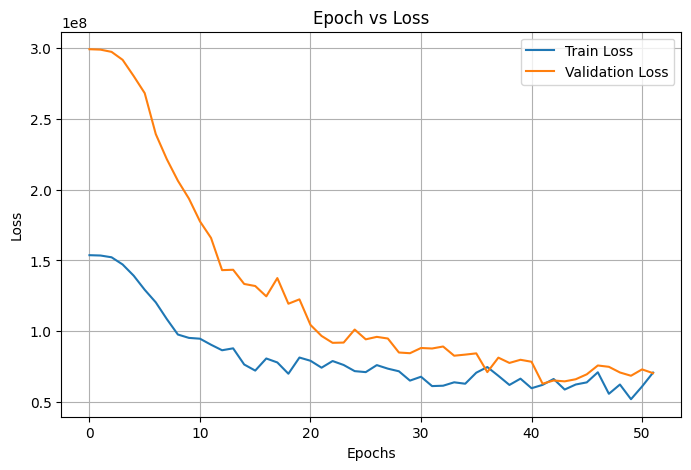

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
CNN Model Evaluation:
MSE: 63050433.59
MAE: 2804.78
R² Score: 0.7744


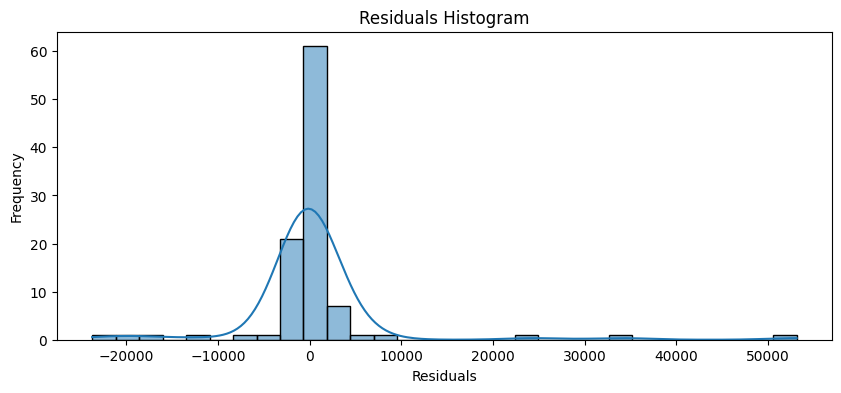

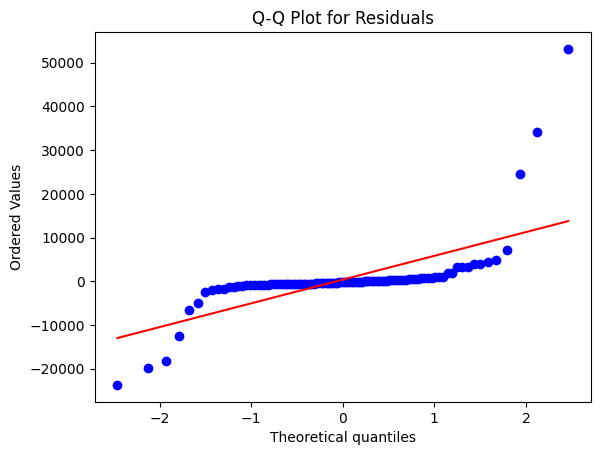

In [22]:
if __name__ == "__main__":
    main()